In [16]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.table as table
import astropy.constants as const

In [7]:
# extinction correction
# coeffs from S&F(2011)
# CTIO B,V
# SDSS g,r
EXTINCTION_COEFF = {
    'B': 3.641,
    'V': 2.681,
    'g': 3.303,
    'r': 2.285
}

In [11]:
# SN 2007Y data
rows = [
    (54154.51, 16.275, 0.015, 16.222, 0.015, 16.48, 0.015, 16.205, 0.015),
    (54161.50, 15.506, 0.015, 15.487, 0.015, 15.692, 0.015, 15.469, 0.015),
    (54170.50, 15.923, 0.015, 15.442, 0.015, 16.349, 0.015, 15.620, 0.015),
    (54179.49, 16.858, 0.015, 16.005, 0.015, 17.492, 0.015, 16.354, 0.015),
    (54190.49, 17.27, 0.015, 16.404, 0.015, 17.915, 0.021, 16.726, 0.015)
]
# from Lyman paper
ebv2007y = 0.112

df2007y = table.Table(rows=rows, names=('mjd', 'mag_g', 'magerr_g', 'mag_r', 'magerr_r', 'mag_B', 'magerr_B', 'mag_V', 'magerr_V'))
df2007y.pprint()
#for band in 'BVgr':
#    df2007y['mag_%s' % band] -= EXTINCTION_COEFF[band] * ebv2007y
#df2007y.pprint()

  mjd    mag_g  magerr_g mag_r  magerr_r mag_B  magerr_B mag_V  magerr_V
-------- ------ -------- ------ -------- ------ -------- ------ --------
54154.51 16.275    0.015 16.222    0.015  16.48    0.015 16.205    0.015
 54161.5 15.506    0.015 15.487    0.015 15.692    0.015 15.469    0.015
 54170.5 15.923    0.015 15.442    0.015 16.349    0.015  15.62    0.015
54179.49 16.858    0.015 16.005    0.015 17.492    0.015 16.354    0.015
54190.49  17.27    0.015 16.404    0.015 17.915    0.021 16.726    0.015
  mjd          mag_g        magerr_g ... magerr_B       mag_V        magerr_V
-------- ------------------ -------- ... -------- ------------------ --------
54154.51          15.905064    0.015 ...    0.015 15.904727999999999    0.015
 54161.5 15.136064000000001    0.015 ...    0.015          15.168728    0.015
 54170.5 15.553064000000001    0.015 ...    0.015          15.319728    0.015
54179.49          16.488064    0.015 ...    0.015          16.053728    0.015
54190.49          16.

In [34]:
# lyman params
lyman_bc_params_gr = np.array([
    0.054, -0.195, -0.719, # c0 c1 c2
    0.076 # rms
])

lyman_bc_params_bv = np.array([
    -0.083, -0.139, -0.691, # c0 c1 c2
    0.109 #rms
])

lyman_cool_params_gr = np.array([
    -0.146, 0.479, -2.257,
    0.078
])
lyman_cool_params_bv = np.array([
    -0.393, 0.786, -2.124,
    0.089
])

COLOR_RANGES = {
    'pbc_gr': (-0.3, 1.0),
    'bc_gr': (-0.3, 1.0),
    'pbc_gi': (-0.8, 1.1),
    'bc_gi': (-0.8, 1.1),
    'bc_bv': (0, 1.3),
    'cool_gr': (-0.3, 0.3),
    'cool_bv': (-0.2, 0.5)
}

VARIANTS = {
    'pbc_gr': ('g', 'r'),
    'bc_gr': ('g', 'r'),
    'pbc_gi': ('g', 'i'),
    'bc_gi': ('g', 'i'),
    'bc_bv': ('B', 'V'),
    'cool_gr': ('g', 'r'),
    'cool_bv': ('B', 'V')
}

def compute_bol_mag(mag_g, mag_r, method):
    if method == 'bc_gr':
        c0, c1, c2, rms = lyman_bc_params_gr
    elif method == 'bc_bv':
        c0, c1, c2, rms = lyman_bc_params_bv
    elif method == 'cool_gr':
        c0, c1, c2, rms = lyman_cool_params_gr
    elif method == 'cool_bv':
        c0, c1, c2, rms = lyman_cool_params_bv
    else:
        raise ValueError('Unknown method: %s' % method)

    dmag = mag_g - mag_r

    # validate color range
    color_min = dmag.min()
    color_max = dmag.max()
    
    if color_min < COLOR_RANGES[method][0]:
        print('* WARN: color in lc exceeds lyman (min lc = %f < %f)' % (color_min, COLOR_RANGES[method][0]))
    if color_max > COLOR_RANGES[method][1]:
        print('* WARN: color in lc exceeds lyman (max lc = %f > %f)' % (color_max, COLOR_RANGES[method][1]))
    invalid = np.logical_or(dmag < COLOR_RANGES[method][0], dmag > COLOR_RANGES[method][1])
    
    bol_correction = c0 + c1*dmag + c2*dmag ** 2
    
    return mag_g + bol_correction, rms, invalid

def convert_luminosity(abs_mag):
    luminosity = (const.L_sun.cgs.value)*10 ** ((4.74 - abs_mag)/2.5)
    return luminosity


Text(0.5, 0, 'MJD')

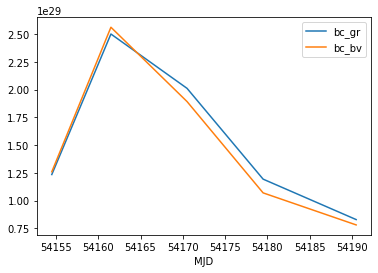

In [35]:
for v in ['bc_gr', 'bc_bv']:
    a_band, b_band = VARIANTS[v]
    mag_a, mag_b = df2007y['mag_%s' % a_band], df2007y['mag_%s' % b_band]
    bol_mag, rms, inv = compute_bol_mag(mag_a, mag_b, v)
    lum = convert_luminosity(bol_mag)
    plt.plot(df2007y['mjd'], lum, label=v)
plt.legend()
plt.xlabel('MJD')

* WARN: color in lc exceeds lyman (min lc = -0.076520 < 0.000000)
* WARN: color in lc exceeds lyman (min lc = -0.400416 < -0.300000)
* WARN: color in lc exceeds lyman (min lc = -0.172520 < 0.000000)
* WARN: color in lc exceeds lyman (min lc = -0.502216 < -0.300000)
* WARN: color in lc exceeds lyman (min lc = -0.268520 < 0.000000)
* WARN: color in lc exceeds lyman (min lc = -0.604016 < -0.300000)
* WARN: color in lc exceeds lyman (min lc = -0.364520 < 0.000000)


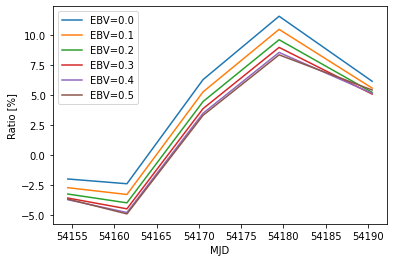

In [33]:
for ebv in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    a_band, b_band = 'g', 'r'
    mag_a, mag_b = df2007y['mag_%s' % a_band] - EXTINCTION_COEFF[a_band]*ebv, df2007y['mag_%s' % b_band] - EXTINCTION_COEFF[b_band]*ebv
    bol_mag, rms = compute_bol_mag(mag_a, mag_b, 'bc_gr')
    lum_gr = convert_luminosity(bol_mag)
    
    a_band, b_band = 'B', 'V'
    mag_a, mag_b = df2007y['mag_%s' % a_band] - EXTINCTION_COEFF[a_band]*ebv, df2007y['mag_%s' % b_band] - EXTINCTION_COEFF[b_band]*ebv
    bol_mag, rms = compute_bol_mag(mag_a, mag_b, 'bc_bv')
    lum_bv = convert_luminosity(bol_mag)
    
    plt.plot(df2007y['mjd'], (lum_gr/lum_bv-1)*100, label='EBV=%.1f' % ebv)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('Ratio [%]')
plt.savefig('2021-02-08-lyman-gr-bv-2007y-comparison.png')

In [26]:
## PTF13bvn dataset
ptf_raw = table.Table.read('../data/comparison/PTF13bvn/raw_lc.dat', format='ascii')
ptf_raw.pprint()
jd_grid = np.linspace(2456462, 2456600)
ptf_interp = {}
for band in 'grBV':
    idx = ptf_raw['band'] == band
    mag = ptf_raw['mag'][idx]
    jd = ptf_raw['JD'][idx]
    if band == 'g':
        jd_max_idx = np.argmin(mag)
        jd_max = jd[jd_max_idx]
    ptf_interp[band] = np.interp(jd_grid, jd, mag)
print('JD max: %f' % jd_max)

     JD      mag   mag_err band telescope
----------- ------ ------- ---- ---------
2456459.738 18.611    0.05    r       P48
2456459.791 18.619    0.05    r       P48
 2456460.74 17.612    0.04    r       P48
2456460.788 17.552    0.04    r       P48
2456460.877 17.668    0.01    i       P60
2456460.878   17.5    0.01    r       P60
2456460.883 17.832    0.01    g       P60
2456461.251 17.906   0.018    B     LCOGT
 2456461.26 17.328   0.015    V     LCOGT
2456461.334 17.627   0.009    g     LCOGT
        ...    ...     ...  ...       ...
 2456685.74 20.349    0.08    r       NOT
2456698.724 21.377   0.077    g       NOT
2456698.739 20.576   0.094    r       NOT
2456721.651 21.811     0.1    g      P200
2456721.663 20.991   0.203    r      P200
2456721.674  20.07    0.15    i       NOT
2456752.955 21.419    0.21    r       NOT
2456752.963 22.231   0.311    g       NOT
2456779.508 22.941   0.289    g       NOT
2456779.523 21.712   0.177    r       NOT
2456813.448 21.995   0.281    r   

EBV=0.0
* WARN: color in lc exceeds lyman (max lc = 1.386675 > 1.300000)
EBV=0.1
EBV=0.2
EBV=0.3
EBV=0.4
EBV=0.5
* WARN: color in lc exceeds lyman (min lc = -0.079838 < 0.000000)


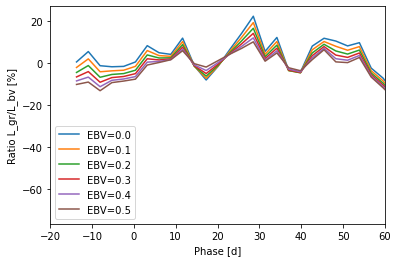

In [49]:
for ebv in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    print('EBV=%.1f' % ebv)
    a_band, b_band = 'g', 'r'
    mag_a, mag_b = ptf_interp[a_band] - EXTINCTION_COEFF[a_band]*ebv, ptf_interp[b_band] - EXTINCTION_COEFF[b_band]*ebv
    bol_mag, rms, inv = compute_bol_mag(mag_a, mag_b, 'bc_gr')
    lum_gr = convert_luminosity(bol_mag)
    
    a_band, b_band = 'B', 'V'
    mag_a, mag_b = ptf_interp[a_band] - EXTINCTION_COEFF[a_band]*ebv, ptf_interp[b_band] - EXTINCTION_COEFF[b_band]*ebv
    bol_mag, rms, inv = compute_bol_mag(mag_a, mag_b, 'bc_bv')
    lum_bv = convert_luminosity(bol_mag)
    
    plt.plot(jd_grid - jd_max, (lum_gr/lum_bv-1)*100, label='EBV=%.1f' % ebv)
plt.legend()
plt.xlabel('Phase [d]')
plt.ylabel('Ratio L_gr/L_bv [%]')
plt.xlim((-20, 60))
plt.savefig('2021-02-08-lyman-gr-bv-ptf13bvn-comparison.png')

* WARN: color in lc exceeds lyman (max lc = 0.986678 > 0.300000)
* WARN: color in lc exceeds lyman (max lc = 1.386675 > 0.500000)
* WARN: color in lc exceeds lyman (max lc = 0.884878 > 0.300000)
* WARN: color in lc exceeds lyman (max lc = 1.290675 > 0.500000)
* WARN: color in lc exceeds lyman (max lc = 0.783078 > 0.300000)
* WARN: color in lc exceeds lyman (max lc = 1.194675 > 0.500000)
* WARN: color in lc exceeds lyman (max lc = 0.681278 > 0.300000)
* WARN: color in lc exceeds lyman (max lc = 1.098675 > 0.500000)
* WARN: color in lc exceeds lyman (max lc = 0.579478 > 0.300000)
* WARN: color in lc exceeds lyman (max lc = 1.002675 > 0.500000)
* WARN: color in lc exceeds lyman (max lc = 0.477678 > 0.300000)
* WARN: color in lc exceeds lyman (max lc = 0.906675 > 0.500000)


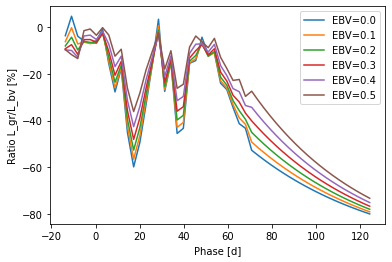

In [32]:
# try cooling
for ebv in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    a_band, b_band = 'g', 'r'
    mag_a, mag_b = ptf_interp[a_band] - EXTINCTION_COEFF[a_band]*ebv, ptf_interp[b_band] - EXTINCTION_COEFF[b_band]*ebv
    bol_mag, rms = compute_bol_mag(mag_a, mag_b, 'cool_gr')
    lum_gr = convert_luminosity(bol_mag)
    
    a_band, b_band = 'B', 'V'
    mag_a, mag_b = ptf_interp[a_band] - EXTINCTION_COEFF[a_band]*ebv, ptf_interp[b_band] - EXTINCTION_COEFF[b_band]*ebv
    bol_mag, rms = compute_bol_mag(mag_a, mag_b, 'cool_bv')
    lum_bv = convert_luminosity(bol_mag)
    
    plt.plot(jd_grid - jd_max, (lum_gr/lum_bv-1)*100, label='EBV=%.1f' % ebv)
plt.legend()
plt.xlabel('Phase [d]')
plt.ylabel('Ratio L_gr/L_bv [%]')
plt.savefig('2021-02-08-lyman-gr-bv-ptf13bvn-cooling-comparison.png')

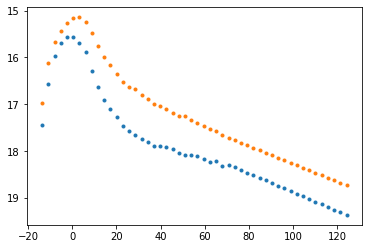

In [44]:
plt.plot(jd_grid - jd_max, ptf_interp['g'])
plt.plot(jd_grid - jd_max, ptf_interp['r'])
plt.gca().invert_yaxis()

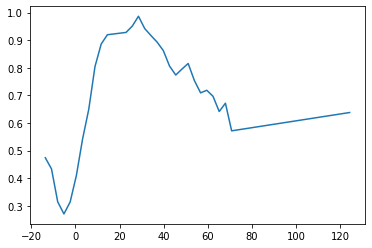

In [41]:
plt.plot(jd_grid - jd_max, ptf_interp['g']-ptf_interp['r'])
#plt.plot(jd_grid - jd_max, ptf_interp['r'])

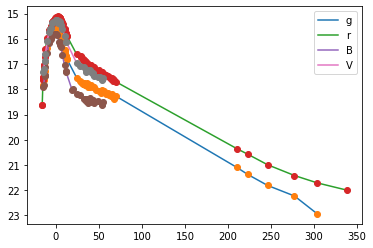

In [50]:
for band in 'grBV':
    idx = ptf_raw['band'] == band
    mag = ptf_raw['mag'][idx]
    jd = ptf_raw['JD'][idx]
    idx = (jd-jd_max)< 1000
    plt.plot((jd-jd_max)[idx], mag[idx], label=band)
    plt.plot((jd-jd_max)[idx], mag[idx], 'o')
plt.legend()
plt.gca().invert_yaxis()